# GA Capstone: Topic Modelling on AMD vs Nvidia GPU

## Contents
- Data Extraction
- Data Cleaning
- [EDA](#EDA)
- [Prepare data for LDA modeling](#Prepare-reddit-comments-for-LDA-modeling)
- [Phrase modeling: Bigram and Trigram models](#Phrase-modeling:-Bigram-and-Trigram-models)
- [LDA Model Training](#LDA-Model-Training)
- [LDA Mallet Model](#LDA-Mallet-Model)
- Model creation
- Model Evaluation

# Import the libraries

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
import os
# import tqdm

import re
# NLTK Library
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Import PRAW package
import praw
from praw.models import MoreComments

# Gensim library
import gensim
from gensim.utils import simple_preprocess, ClippedCorpus
from gensim.models import LdaMulticore, CoherenceModel, Phrases
from gensim.models.wrappers import LdaMallet
from gensim.models.phrases import Phraser
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora

# pyLDAvis library
import pyLDAvis.gensim
import pickle 
import pyLDAvis

# Detect non-english words
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Detect non-english words using spacy
import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)


# Import the wordcloud library
from wordcloud import WordCloud

# Removes depreciation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [2]:
# Set the max rows and columns for Pandas
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [3]:
# Set the style use
plt.style.use('ggplot')

## Create a helper function to scrap the dataset in reddit

In [4]:
# Create a dictionary with keys as the text and the value being reddit submission id 
nvidia_gpu_sub_dict = {'rtx_3060ti': 'k4mctp', 'rtx_3070':'jj8k0l', 
                       'rtx_3080': 'itw87x', 'rtx_3090': 'iyy5sx', 'rtx_3000': 'iko4ir'}
amd_gpu_sub_dict = {'amd_gpu': 'iknr7g', 'rx_6000_rdna2':'jjq6v1', 'rx_6000_nov_18':'jvxm8z', 'radeon_rx_6000':'jwesyt'} 

In [5]:
# Additional nvidia comments scrapped
add_nvidia_gpu_sub_dict = {'rtx_3090vs3080vs3070': 'ioyjk6', 'scalper_warning': 'ivi4qm', 'rtx_3090_memory': 'igw0bg',
                          'rtx_3080ti_priced': 'jrmtmx', 'rtx_3080_3090_leak': 'ii6179'}

In [6]:
 reddit = praw.Reddit(
     client_id="IR7Y4cUBrVAbGg",
     client_secret="podr43kzztn_CoVgtNQiNpDfjI5mjg",
     user_agent="gpu_scrapper_32",
     username="leader2345",
     password="rPLHgrS8"
 )

In [7]:
def scrapeGPUComment(gpu_dict):
    for key, value in gpu_dict.items():
        # Creates the GPU list to hold the reddit comments
        gpu_lst = []
        # Creating the submission object for rtx megathreads
        submission = reddit.submission(id=value)
        
        # Extract all the commments
        submission.comments.replace_more(limit=None)
        for comment in submission.comments.list():
            gpu_lst.append(comment.body)
        # Converted to Dataframe format
        rtx_df = pd.DataFrame({'Reddit comments':gpu_lst})
        # Creating the column for tags, the keys of the dictionary will be stored here
        rtx_df['tag'] = key
        # Export the individual submissions to csv file
        rtx_df.to_csv('./reddit dataset/' + key + '.csv', index=False)

In [8]:
# Scrapping of nvidia commments
# scrapeGPUComment(nvidia_gpu_sub_dict)

In [9]:
# Scrapping of amd commments
# scrapeGPUComment(amd_gpu_sub_dict)

In [10]:
# Scrapping of additional nvidia commments
# scrapeGPUComment(add_nvidia_gpu_sub_dict)

In [11]:
# Read in the dataframes

# Nvidia's comments
rtx_3000 = pd.read_csv('./reddit dataset/rtx_3000.csv')
rtx_3060ti = pd.read_csv('./reddit dataset/rtx_3060ti.csv')
rtx_3070 = pd.read_csv('./reddit dataset/rtx_3070.csv')
rtx_3080 = pd.read_csv('./reddit dataset/rtx_3080.csv')
rtx_3090 = pd.read_csv('./reddit dataset/rtx_3090.csv')

# Amd's comments
amd_gpu = pd.read_csv('./reddit dataset/amd_gpu.csv')
rx_6000 = pd.read_csv('./reddit dataset/radeon_rx_6000.csv')
rx_6000_nov_18 = pd.read_csv('./reddit dataset/rx_6000_nov_18.csv')
rx_6000_rdna2 = pd.read_csv('./reddit dataset/rx_6000_rdna2.csv')

# Additional Nvidia's comments scrapped
rtx_3090vs3080vs3070 = pd.read_csv('./reddit dataset/rtx_3090vs3080vs3070.csv')
scalper_warning = pd.read_csv('./reddit dataset/scalper_warning.csv')
rtx_3090_memory = pd.read_csv('./reddit dataset/rtx_3090_memory.csv')
rtx_3080ti_priced = pd.read_csv('./reddit dataset/rtx_3080ti_priced.csv')
rtx_3080_3090_leak = pd.read_csv('./reddit dataset/rtx_3080_3090_leak.csv')

In [12]:
# Concat the dataframes by their rows
combined_df = pd.concat([rtx_3000, rtx_3060ti, rtx_3070, rtx_3080,
                        rtx_3090, amd_gpu, rx_6000, rx_6000_nov_18, rx_6000_rdna2,
                        rtx_3090vs3080vs3070, scalper_warning, rtx_3090_memory, rtx_3080ti_priced, rtx_3080_3090_leak],
                       axis=0, ignore_index = False)

# Data cleaning

## Removing the null values

In [13]:
# Check the dimensions of the data
combined_df.shape

(34534, 2)

In [14]:
# Checking for null values
combined_df.isnull().sum()

Reddit comments    3
tag                0
dtype: int64

In [15]:
# Check for null values
combined_df.dropna(inplace = True)

In [16]:
# Checking for null values
combined_df.isnull().sum()

Reddit comments    0
tag                0
dtype: int64

## Dropping comments with `[deleted]` and `[removed]` in them

In [17]:
combined_df.shape

(34531, 2)

In [18]:
removed_deleted_comments_idx = combined_df[(combined_df['Reddit comments'] == '[removed]') | (combined_df['Reddit comments'] == '[deleted]')].index
removed_deleted_comments_idx

Int64Index([  46,   56,   57,   82,   83,  118,  150,  157,  160,  244,
            ...
            2240, 2321, 2343, 2348, 2350, 2364, 2407, 2422, 2425, 2436],
           dtype='int64', length=778)

A total of 778 comments will be dropped from the dataframe.

In [19]:
# Drop the deleted and removed comments
combined_df.drop(removed_deleted_comments_idx, axis=0, inplace = True)

In [20]:
combined_df.shape

(28809, 2)

## Cleaning the Reddit comments

In [21]:
# Full function to clean the title and the post
def clean_post(df):
    """
    This function removes the unnecessary characters, punctuations, removes stop words and lemmantizes the words
    from the posts and titles. Lemmantization is used as I want to preserve the meaning of the words in which it'll compare the words against a dictionary.
    """
    new_lst = []
    
    # Stop words
    stop_words = set(STOPWORDS).union(stopwords.words("english")) # Combines gensim stopwords and nltk's stopwords
    stop_words = stop_words.union(['http', 'www', 'youtube' 'get', 'like', '1', '2', '3', '5', 'got'])
    
    # Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    for post in df:
        # Lowercase the text
        post = post.lower()

        # Find the https websites and removes them
        post = re.sub(r'http\S+','',post)

        # Removes youtube links
        #post = re.sub('https:.*?\\n','',post)

        # Removes uncaptured url links at the bottom of the text
        post = re.sub('https.*?[\\n|"]','',post)

        # Removes characters: \n\n&amp;#x200B;
        post = re.sub('\\n\\n&amp;#x200b;\\n\\n','',post)

        # Removing the special characters, like punctuation marks, periods
        post = re.sub(r'[^\w]',' ',post)
        
        # Removes digits and keeps the letters
        # post = re.sub(r'[^a-zA-Z]', ' ', post)

        # Removes underscores
        post = re.sub(' _', ' ',post)

        # Removes addtional white spaces
        post = re.sub(' +', ' ',post)
        
        # Stores the words in a list 
        lst = [lemmatizer.lemmatize(word) for word in post.split() if not word in stop_words]
            
        new_lst.append(" ".join(lst))
        
    return new_lst

In [22]:
# Cleans the Reddit comments column
combined_df['Reddit comments'] = clean_post(combined_df['Reddit comments'])
combined_df['Reddit comments']

0                           pre order time releasing 17th
2                          going hard grab card 3080 17th
4       uk price 3090 1399 3080 649 3070 469 scan aib ...
5       badly want 3080 especially price concerned 10g...
6                              talking spatula jensen pot
                              ...                        
2433                    motherboard say pcie 0 compatible
2434    thanks understanding know course 3000s dvi por...
2435                                         buy 1400 gpu
2437                          lol know ill wait 3070 3060
2438    generational compatibility compatible size pci...
Name: Reddit comments, Length: 28809, dtype: object

In [23]:
# Checking for stop words
combined_df['Reddit comments'][combined_df['Reddit comments'].map(lambda word:'http' in word)].values

array([], dtype=object)

## Dropping comments that are empty

In [24]:
combined_df.describe()

,Reddit comments,tag
count,28809,28809
unique,27700,14
top,,rx_6000_rdna2
freq,305,9869


In [25]:
(combined_df['Reddit comments'] == '').sum()

305

There are 213 empty comments that have to be dropped.

In [26]:
empty_comments_idx = combined_df[combined_df['Reddit comments'] == ''].index
combined_df.drop(empty_comments_idx, axis=0, inplace=True)

In [27]:
(combined_df['Reddit comments'] == '').sum()

0

The empty comments have been removed.

## Setting the tags with either `Nvidia` or `Amd`

In [28]:
combined_df['tag'].unique()

array(['rtx_3000', 'rtx_3060ti', 'rtx_3070', 'rtx_3080', 'rtx_3090',
       'amd_gpu', 'radeon_rx_6000', 'rx_6000_nov_18', 'rx_6000_rdna2',
       'rtx_3090vs3080vs3070', 'scalper_warning', 'rtx_3090_memory',
       'rtx_3080ti_priced', 'rtx_3080_3090_leak'], dtype=object)

These tags need to be renamed to either `Nvidia` or `Amd`

In [29]:
nvidia_tag_lst = list(nvidia_gpu_sub_dict) + list(add_nvidia_gpu_sub_dict)
amd_tag_lst = list(amd_gpu_sub_dict)

In [30]:
print(nvidia_tag_lst)
print(amd_tag_lst)

['rtx_3060ti', 'rtx_3070', 'rtx_3080', 'rtx_3090', 'rtx_3000', 'rtx_3090vs3080vs3070', 'scalper_warning', 'rtx_3090_memory', 'rtx_3080ti_priced', 'rtx_3080_3090_leak']
['amd_gpu', 'rx_6000_rdna2', 'rx_6000_nov_18', 'radeon_rx_6000']


In [31]:
combined_df['tag'].replace(nvidia_tag_lst, ['nvidia' for _ in range(len(nvidia_tag_lst))], inplace = True)
combined_df['tag'].replace(amd_tag_lst, ['amd' for _ in range(len(amd_tag_lst))], inplace = True)

In [32]:
combined_df['tag'].value_counts()

amd       15385
nvidia    11411
Name: tag, dtype: int64

## Removing duplicates in the dataframe

In [33]:
combined_df.duplicated(subset='Reddit comments', keep = False).sum()

1050

In [34]:
combined_df[combined_df.duplicated(subset='Reddit comments', keep = False)]

,Reddit comments,tag
58,pre order,nvidia
130,pre order,nvidia
147,spatula,nvidia
408,scared new mining performance card new memory ...,nvidia
450,3060,nvidia
...,...,...
2069,wait benchmark,nvidia
2131,case,nvidia
2261,think,nvidia
2405,good bot,nvidia


There are 1061 comments that are duplicated and have to be dropped.

In [35]:
combined_df.shape

(26796, 2)

In [36]:
combined_df.drop_duplicates(subset='Reddit comments', keep = False, ignore_index= True, inplace = True)

In [37]:
combined_df.shape

(25746, 2)

In [38]:
combined_df.duplicated(subset='Reddit comments', keep = False).sum()

0

The duplicated comments have been removed.

In [39]:
# Randomly going through the rows to check if it's cleaned properly 
combined_df['Reddit comments'].loc[np.random.randint(1707)]

'_dusts spam purchase form filling bot'

### Removing non-english words in the reviews (Possible to ignore)

In [40]:
# # Removing non english by creating a helper function
# from langdetect import detect
# def isenglish(text):
#     try:
#         if nlp(text)._.language.get('language') == 'en':
#             return 1
#         else:
#             return 0
#     except:
#         return 0

In [41]:
# GPU_df['isenglish'] = GPU_df['Customer Review'].apply(isenglish)

In [42]:
# GPU_df[GPU_df.loc[:,'isenglish'] == 0][['Customer Review']].head(10)

In [43]:
# Count number of rows with the string deleted in them
# GPU_df['Customer Review'].map(lambda x: x.count('deleted')).sum()

In [44]:
# GPU_df[GPU_df.loc[:,'isenglish'] == 0][['Customer Review']].count()

A total of 130 rows were non-english reviews. These have to be removed.

## Exporting the cleaned csv file 

In [45]:
# Save to csv file
combined_df.to_csv('./reddit dataset/cleaned_combined_df.csv', index=False)

# EDA on the comments

In [5]:
# Read the existing csv file
GPU_df = pd.read_csv('./reddit dataset/cleaned_combined_df.csv')
GPU_df

,Reddit comments,tag
0,pre order time releasing 17th,nvidia
1,going hard grab card 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,talking spatula jensen pot,nvidia
4,10k core completely insane,nvidia
...,...,...
25741,motherboard say pcie 0 compatible,nvidia
25742,thanks understanding know course 3000s dvi por...,nvidia
25743,buy 1400 gpu,nvidia
25744,lol know ill wait 3070 3060,nvidia


In [47]:
GPU_df.describe()

,Reddit comments,tag
count,25746,25746
unique,25746,2
top,wait 80cu unit,amd
freq,1,14642


In [48]:
GPU_df.shape

(25746, 2)

In [49]:
# Check for null values
GPU_df.isnull().sum()

Reddit comments    0
tag                0
dtype: int64

In [50]:
# Checking for duplicated comments
GPU_df.duplicated(subset='Reddit comments', keep=False).sum()

0

## Distribution of AMD and Nvidia comments

In [51]:
GPU_df['tag'].value_counts(normalize=True) * 100

amd       56.87097
nvidia    43.12903
Name: tag, dtype: float64

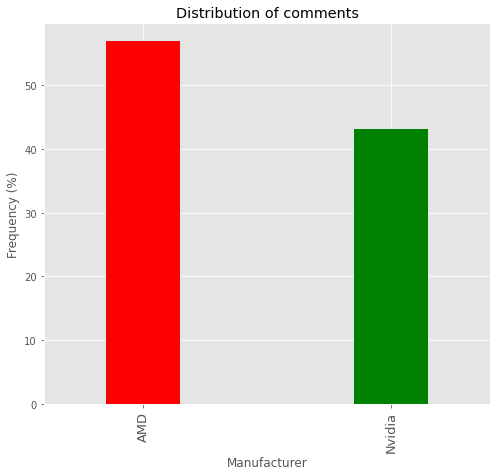

In [52]:
(GPU_df['tag'].value_counts(normalize=True) * 100).plot(kind='bar', 
                                                        title='Distribution of comments',
                                                        figsize=(8,7),
                                                        xlabel = 'Manufacturer',
                                                       ylabel='Frequency (%)',
                                                       color = ['red','green'],
                                                       width=0.3)

plt.xticks(np.arange(2), ['AMD', 'Nvidia'],fontsize=13);

In the dataset, around 56% of the comments were from AMD and the Hardware subreddit and 43% of the comments were from Nvidia's subreddit.

## EDA on Amd comments

In [6]:
# Obtaining only AMD comments
amd_df = GPU_df[GPU_df['tag'] == 'amd']
amd_df

,Reddit comments,tag
4737,sound samsung 8nm cheap,amd
4738,ethic mongol invasion tech,amd
4739,nvidia software ai learning big selling point,amd
4740,excited amd guy compete going nvidia brand loy...,amd
4741,think nvidia actualy competing new console pri...,amd
...,...,...
19374,dude understand example confused said looked r...,amd
19375,know example thought looked,amd
19376,probably score higher english proficiency test...,amd
19377,prove know concept cost opportunity efficiency...,amd


### Distribution of text for AMD comments

In [54]:
# Obtain the length of of each post and store the values in length
textlength = amd_df['Reddit comments'].apply(lambda x:len(x.split())).rename('textlength')
textlength

4737      4
4738      4
4739      7
4740      9
4741     12
         ..
19374     9
19375     4
19376     8
19377    12
19378    16
Name: textlength, Length: 14642, dtype: int64

In [55]:
amd_df = pd.concat([amd_df, textlength], axis=1)
amd_df

,Reddit comments,tag,textlength
4737,sound samsung 8nm cheap,amd,4
4738,ethic mongol invasion tech,amd,4
4739,nvidia software ai learning big selling point,amd,7
4740,excited amd guy compete going nvidia brand loy...,amd,9
4741,think nvidia actualy competing new console pri...,amd,12
...,...,...,...
19374,dude understand example confused said looked r...,amd,9
19375,know example thought looked,amd,4
19376,probably score higher english proficiency test...,amd,8
19377,prove know concept cost opportunity efficiency...,amd,12


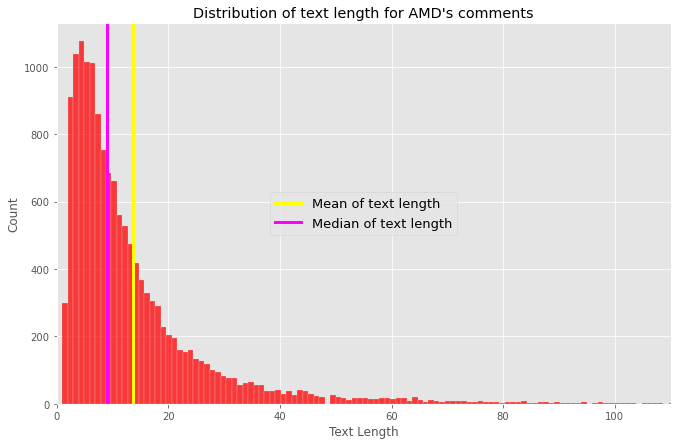

In [56]:
# Plotting the histogram of the textlength
plt.figure(figsize=(11,7))
sns.histplot(amd_df['textlength'], color='red')

plt.title("Distribution of text length for AMD's comments")

# Plot the mean of the distribution
plt.axvline(amd_df['textlength'].mean(), color='yellow', linewidth=3, label = 'Mean of text length')
plt.axvline(amd_df['textlength'].median(), color='magenta', linewidth=3, label = 'Median of text length')

plt.xlabel('Text Length')
plt.legend(fontsize=13, loc='center')
plt.xlim(0,110);

In [57]:
print(f"Mean of AMD's text length is {amd_df['textlength'].mean()}.")
print(f"Median of AMD's text length is {amd_df['textlength'].median()}.")

Mean of AMD's text length is 13.74067750307335.
Median of AMD's text length is 9.0.


The distribution shows a right tailed histogram with posts length having a mean of 15 and a median of 10.

### Frequently occurring words in AMD comments 

In [58]:
# Obtaining the frequency of the tokens
amd_comments_lst = list(" ".join(amd_df['Reddit comments']).split())
amd_comments_dict = {}

# Creates a frequency dictionary
for word in amd_comments_lst:
    if word not in amd_comments_dict.keys():
        amd_comments_dict[word] = amd_comments_lst.count(word)
    else:
        continue
        
amd_comments_dict

{'sound': 124,
 'samsung': 110,
 '8nm': 57,
 'cheap': 94,
 'ethic': 3,
 'mongol': 14,
 'invasion': 3,
 'tech': 191,
 'nvidia': 2592,
 'software': 231,
 'ai': 113,
 'learning': 50,
 'big': 450,
 'selling': 111,
 'point': 506,
 'excited': 57,
 'amd': 3661,
 'guy': 177,
 'compete': 256,
 'going': 901,
 'brand': 82,
 'loyalty': 20,
 'sucker': 12,
 'think': 1153,
 'actualy': 1,
 'competing': 69,
 'new': 750,
 'console': 506,
 'price': 1681,
 '499': 93,
 '2080ti': 411,
 'performance': 2105,
 'dumping': 1,
 'reputable': 5,
 'leak': 63,
 'rdna2': 190,
 'say': 96,
 '40': 62,
 '50': 373,
 'faster': 383,
 'couple': 99,
 'rumored': 23,
 'focus': 30,
 'power': 473,
 'efficiency': 63,
 'advantage': 120,
 'tsmc': 116,
 'process': 74,
 '7nm': 108,
 'forget': 55,
 'silicon': 29,
 'pushed': 28,
 '350': 59,
 'tdp': 53,
 'impossible': 25,
 'raise': 26,
 'coming': 196,
 'competitive': 175,
 'want': 708,
 'buy': 743,
 'potentially': 18,
 'lower': 355,
 'waiting': 219,
 'im': 159,
 'sure': 546,
 'good': 985,

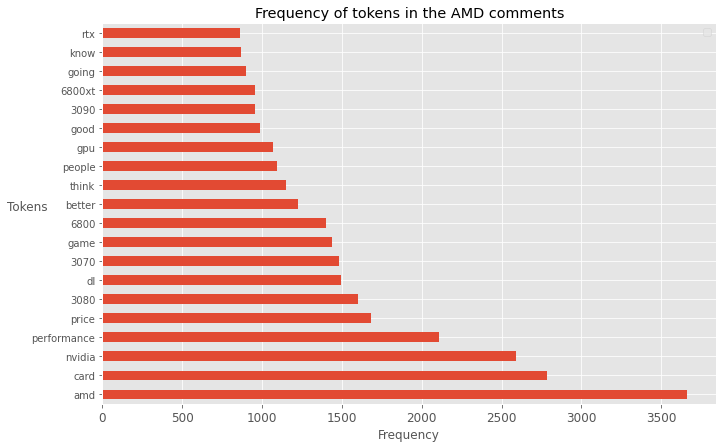

In [59]:
amd_freq_df = pd.DataFrame({'words': amd_comments_dict.keys(), 'freq': amd_comments_dict.values()})
amd_freq_df.sort_values('freq', ascending=False).set_index('words').head(20).plot(kind='barh', figsize=(11,7),
                                                                                          title='Frequency of tokens in the AMD comments')

plt.xlabel('Frequency')
plt.ylabel('Tokens', rotation=360)
plt.xticks(fontsize=12)
plt.legend([]);

Other than `amd`, `nvidia` and `card`, it seems that the most commonly occuring words are `performance`, `price`, Nvidia's GPU models the Rtx [`3080`](https://www.nvidia.com/en-sg/geforce/graphics-cards/30-series/rtx-3080/), Rtx [`3070`](https://www.nvidia.com/en-sg/geforce/graphics-cards/30-series/rtx-3070/) and AMD's [`6800`](https://www.amd.com/en/products/graphics/amd-radeon-rx-6800). These type of GPUs are catered towards enthusiast grade gamers who play in resolutions of 1440p and upwards and at frames above 60. The `dl` likely refers to Nvidia's DLSS (Deep Learning Super Sampling) which uses the Tensor core AI processors on the GPU to boost frame rates and render beautiful and sharp images in games. Surprisingly, only one AMD model, the 6800, made it to the top frequent tokens list, which highlights the popularity behind Nvidia's cards. 

### Word cloud on AMD's comments

In [60]:
amd_string = " ".join(amd_df['Reddit comments'])

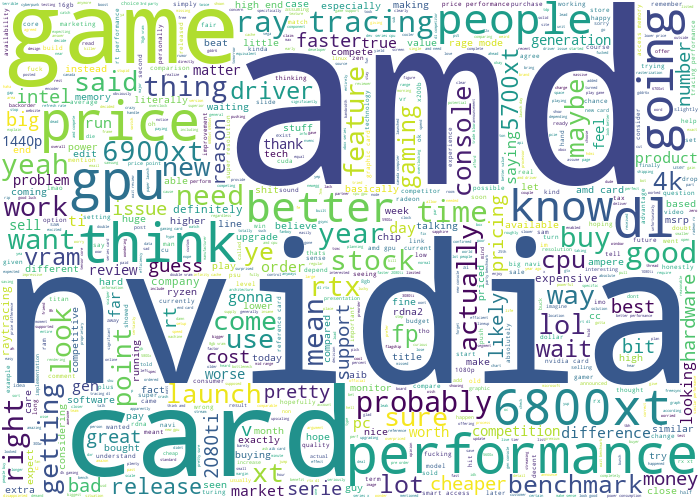

In [61]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=5, contour_color='steelblue', width=700, height=500)
wordcloud.generate(amd_string)
# Visualize the word cloud
wordcloud.to_image()

These tokens look similar to the frequency distribution graph that was created previously.

### Longest AMD comment

In [62]:
amd_df.sort_values(by='textlength', ascending=False).iloc[0].values

array(['example ray tracing insanely computationally expensive push higher higher resolution jumping 1080p 1440p 4k adding big load gpus ray tracing exacerbates essentially enabling ray tracing half performance huge performance hit think agree exactly dl important negates halving ray tracing guarantee devs away completely fake baking lighting cube map use rtx know long way away unfortunately yes computationally expensive far easier devs implement physic based work box hundred hour cube map hit generally getting ray tracing effect certain area example ray traced environmental lighting effect muzzle trade lighting option severe performance penalty yep absolute best implementation control far good cyberpunk implementation albeit bet extremely good given close partnership nvidia said implementation computational cost high best cast ray pixel enormously far realistic rendering theoretically say need cast 500 ray pixel simulate true ray pixel extremely obvious ray tracing active game impleme

The comments talks about ray tracing, which is a feature exclusive to Nvidia which provides realistic lighting in games, that is found to be computationally expensive and causes performance to drop significantly for the previous generation of GPUs, the Rtx 2000 series. But the newly released RTX 3000 series provides better performance using ray tracing.

## EDA on Nvidia comments

In [63]:
# Obtaining only AMD comments
nvidia_df = GPU_df[GPU_df['tag'] == 'nvidia']
nvidia_df

,Reddit comments,tag
0,pre order time releasing 17th,nvidia
1,going hard grab card 3080 17th,nvidia
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia
3,talking spatula jensen pot,nvidia
4,10k core completely insane,nvidia
...,...,...
25741,motherboard say pcie 0 compatible,nvidia
25742,thanks understanding know course 3000s dvi por...,nvidia
25743,buy 1400 gpu,nvidia
25744,lol know ill wait 3070 3060,nvidia


### Distribution of text for Nvidia comments

In [64]:
# Obtain the length of of each post and store the values in length
textlength = nvidia_df['Reddit comments'].apply(lambda x:len(x.split())).rename('textlength')
textlength

0         5
1         6
2        18
3         4
4         4
         ..
25741     5
25742    86
25743     3
25744     6
25745    26
Name: textlength, Length: 11104, dtype: int64

In [65]:
nvidia_df = pd.concat([nvidia_df, textlength], axis=1)
nvidia_df

,Reddit comments,tag,textlength
0,pre order time releasing 17th,nvidia,5
1,going hard grab card 3080 17th,nvidia,6
2,uk price 3090 1399 3080 649 3070 469 scan aib ...,nvidia,18
3,talking spatula jensen pot,nvidia,4
4,10k core completely insane,nvidia,4
...,...,...,...
25741,motherboard say pcie 0 compatible,nvidia,5
25742,thanks understanding know course 3000s dvi por...,nvidia,86
25743,buy 1400 gpu,nvidia,3
25744,lol know ill wait 3070 3060,nvidia,6


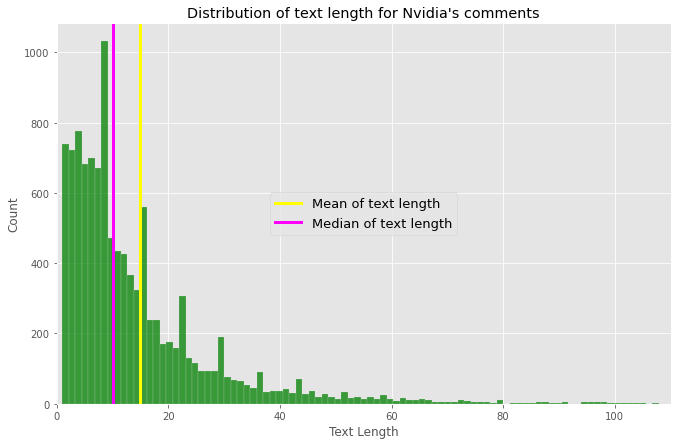

In [66]:
# Plotting the histogram of the textlength
plt.figure(figsize=(11,7))
sns.histplot(nvidia_df['textlength'], color='green')

plt.title("Distribution of text length for Nvidia's comments")

# Plot the mean of the distribution
plt.axvline(nvidia_df['textlength'].mean(), color='yellow', linewidth=3, label = 'Mean of text length')
plt.axvline(nvidia_df['textlength'].median(), color='magenta', linewidth=3, label = 'Median of text length')

plt.xlabel('Text Length')
plt.legend(fontsize=13, loc='center')
plt.xlim(0,110);

In [67]:
print(f"Mean of Nvidia's text length is {nvidia_df['textlength'].mean()}")
print(f"Median of Nvidia's text length is {nvidia_df['textlength'].median()}")

Mean of Nvidia's text length is 14.953440201729107
Median of Nvidia's text length is 10.0


Similar to the text length of AMD's comments dataframe, it shows a right skewed histogram with the text length for Nvidia's comment has a mean of 17 and median of 12 which are slightly higher compared to AMD's comments.

## Frequently occurring words in Nvidia's comments

In [68]:
# Obtaining the frequency of the tokens
nvidia_comments_lst = list(" ".join(nvidia_df['Reddit comments']).split())
nvidia_comments_dict = {}

In [69]:
# Creates a frequency dictionary
for word in nvidia_comments_lst:
    if word not in nvidia_comments_dict.keys():
        nvidia_comments_dict[word] = nvidia_comments_lst.count(word)
    else:
        continue
        
nvidia_comments_dict

{'pre': 92,
 'order': 183,
 'time': 875,
 'releasing': 48,
 '17th': 61,
 'going': 890,
 'hard': 169,
 'grab': 36,
 'card': 2648,
 '3080': 2244,
 'uk': 64,
 'price': 1218,
 '3090': 1661,
 '1399': 11,
 '649': 12,
 '3070': 703,
 '469': 3,
 'scan': 24,
 'aib': 211,
 'thanks': 186,
 'u': 53,
 'benzyl': 1,
 'chloride': 1,
 'overclockers': 17,
 'talking': 136,
 'spatula': 3,
 'jensen': 32,
 'pot': 1,
 '10k': 18,
 'core': 336,
 'completely': 63,
 'insane': 81,
 'rip': 27,
 '2080': 557,
 'ti': 861,
 'resale': 17,
 'value': 168,
 'x200b': 91,
 'cry': 24,
 'shit': 207,
 'actually': 431,
 'better': 635,
 'people': 1137,
 'expected': 48,
 'expensive': 145,
 'shader': 17,
 'tflop': 4,
 'number': 182,
 'real': 153,
 'world': 95,
 'fp': 6,
 'performance': 1085,
 'holy': 34,
 'fucking': 112,
 'christ': 13,
 'massive': 97,
 'upgrade': 535,
 'beating': 15,
 'pascal': 57,
 'send': 25,
 'money': 431,
 'question': 134,
 'nvidia': 1162,
 '3xxx': 6,
 'series': 561,
 'page': 59,
 'reporting': 6,
 'exactly': 11

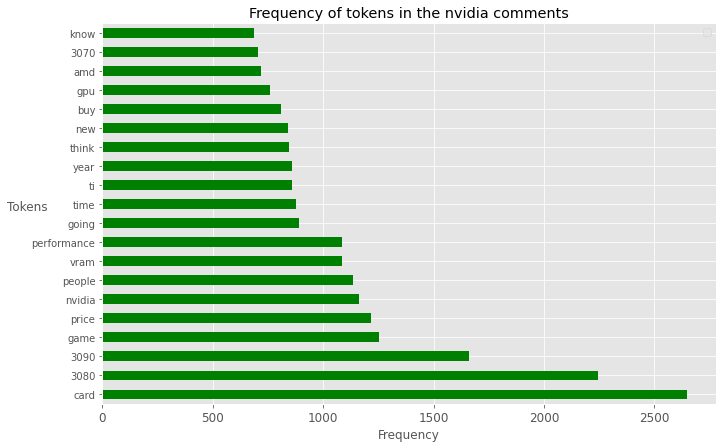

In [70]:
nvidia_freq_df = pd.DataFrame({'words': nvidia_comments_dict.keys(), 'freq': nvidia_comments_dict.values()})
nvidia_freq_df.sort_values('freq', ascending=False).set_index('words').head(20).plot(kind='barh', figsize=(11,7),
                                                                                          color = 'green',
                                                                                          title='Frequency of tokens in the nvidia comments')

plt.xlabel('Frequency')
plt.ylabel('Tokens', rotation=360)
plt.xticks(fontsize=12)
plt.legend([]);

Tokens that were found in AMD's comments are also are found in Nvidia's most frequent tokens, tokens such as `3080`, `card`, `game`, `performance`. Nvidia's RTX 3080 GPU model seems to be the popular among gamers as it was found in both AMD's and Nvidia's comments. The consumers are `price` and `performance` driven given these tokens appear in both subreddits and it attracts gamers given the word `game` has occurred in both the subreddits. `vram`, known as video ram, seems to play an important feature when purchasing video cards as it helps to shorten loading times and improving image quality. Certain levels of VRAM are necessary for games to run at different resolutions. For example, rendering a game at 1080p resolution is different than rendering a game at 4K resolution, which requires more graphics memory.

### Word cloud on Nvidia's comments

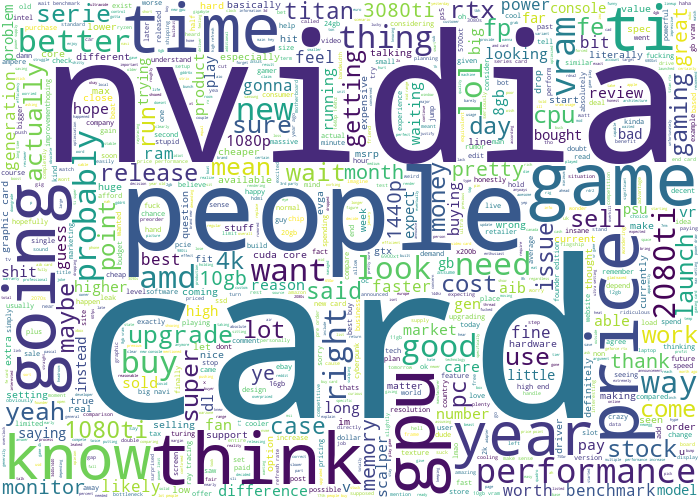

In [71]:
# Word cloud on Nvi's comments
nvidia_string = " ".join(nvidia_df['Reddit comments'])

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, 
                      contour_width=5, contour_color='steelblue', width=700, height=500)
wordcloud.generate(nvidia_string)

# Visualize the word cloud
wordcloud.to_image()

The graph shows consistency with the word cloud on the frequency of the words appearing in Nvidia's comments.

# Prepare comments for modeling

In [7]:
# Creates the bag of words for each document
data = [token.split() for token in amd_df['Reddit comments'].tolist()]

In [8]:
# Prints the bag of words from the first 3 documents
print(data[:3])

[['sound', 'samsung', '8nm', 'cheap'], ['ethic', 'mongol', 'invasion', 'tech'], ['nvidia', 'software', 'ai', 'learning', 'big', 'selling', 'point']]


## Phrase modeling: Bigram and Trigram models

In [9]:
# Build the bigram and trigram models
bigram = Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram, this reduces memory, making the model smaller and faster
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_bigrams = make_bigrams(data)

# Form Trigrams
data_trigrams = make_trigrams(data)

## LDA on AMD comments with unigrams

In [76]:
# Create Dictionary
unigram_id2word = corpora.Dictionary(data)

# Term Document Frequency
unigram_corpus = [unigram_id2word.doc2bow(text) for text in data]

# (token, token_id)
# print(id2word.token2id)

In [77]:
# View
# (token_id, token_frequency)
print(unigram_corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


## Unigram LDA Model Training on AMD comments

In [78]:
# number of topics
num_topics = 10

# Build LDA model
unigram_lda_model = LdaMulticore(corpus=unigram_corpus, 
                         id2word=unigram_id2word, 
                         num_topics=num_topics,
                         chunksize=100,
                         passes=20, 
                         random_state=42,
                        per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(unigram_lda_model.print_topics())
unigram_doc_lda = unigram_lda_model[unigram_corpus]

[(0,
  '0.044*"game" + 0.044*"dl" + 0.029*"ray" + 0.026*"tracing" + '
  '0.017*"performance" + 0.015*"rt" + 0.012*"feature" + 0.009*"support" + '
  '0.009*"rtx" + 0.008*"raytracing"'),
 (1,
  '0.039*"power" + 0.014*"cache" + 0.012*"know" + 0.009*"watt" + 0.009*"lmao" '
  '+ 0.008*"memory" + 0.008*"sure" + 0.008*"ok" + 0.007*"think" + '
  '0.007*"consumption"'),
 (2,
  '0.040*"3070" + 0.039*"6800" + 0.034*"3080" + 0.027*"performance" + '
  '0.023*"price" + 0.023*"6800xt" + 0.022*"3090" + 0.020*"vram" + '
  '0.015*"better" + 0.015*"6900xt"'),
 (3,
  '0.036*"amd" + 0.029*"nvidia" + 0.027*"card" + 0.016*"price" + 0.013*"end" + '
  '0.011*"people" + 0.010*"buy" + 0.009*"going" + 0.009*"time" + 0.008*"gpu"'),
 (4,
  '0.017*"amd" + 0.016*"monitor" + 0.012*"issue" + 0.010*"thanks" + '
  '0.009*"psu" + 0.009*"work" + 0.008*"gpu" + 0.008*"mean" + 0.007*"run" + '
  '0.007*"pc"'),
 (5,
  '0.014*"console" + 0.012*"yes" + 0.012*"year" + 0.011*"upgrade" + '
  '0.011*"6700" + 0.011*"pc" + 0.010*"look"

In [79]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'unigram_' + 'ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(unigram_lda_model, unigram_corpus, unigram_id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+ '\\visualization\\' + 'unigram_' + 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.112413  0.005498       1        1  18.067617
2      0.029868  0.225253       2        1  16.328831
0      0.097900  0.051779       3        1  13.884597
8      0.145215  0.043919       4        1  12.076052
7      0.100605 -0.051944       5        1   9.223272
9     -0.051938 -0.141659       6        1   8.992858
4      0.043034 -0.162875       7        1   7.867327
5     -0.034040  0.050478       8        1   5.395972
1     -0.150898 -0.128638       9        1   4.888836
6     -0.292160  0.108189      10        1   3.274639, topic_info=            Term         Freq        Total Category  logprob  loglift
5386        6800  1301.000000  1301.000000  Default  30.0000  30.0000
100         3070  1380.000000  1380.000000  Default  29.0000  29.0000
395           dl  1484.000000  1484.000000  Default  28.0000  28.0000
319         game  1396.000000  1396.000000  Default  27.0000  27.0000
15           amd  3320.000000  3320.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
101         3080    58.392209  1409.980567  Topic10  -4.7259   0.2348
100         3070    47.548184  1380.288334  Topic10  -4.9313   0.0507
307          lol    37.449409   423.675483  Topic10  -5.1701   0.9930
1115  comparison    34.520279   157.136465  Topic10  -5.2515   1.9034
249         know    36.774169   827.769711  Topic10  -5.1883   0.3050

[694 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
426       3  0.811809     0
426       6  0.073449     0
426       9  0.104375     0
426      10  0.007732     0
827       1  0.075070    10
...     ...       ...   ...
735       7  0.065742   yes
735       8  0.333967   yes
735       9  0.089408   yes
2263     10  0.972634   yup
4097      4  0.979796  zen3

[1493 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 9, 8, 10, 5, 6, 2, 7])

### Notes on the pyLDAvis bubbles

* Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.

* Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.

* Red bars give the estimated number of times a given term was generated by a given topic. As you can see from the image below, there are about 22,000 of the word ‘go’, and this term is used about 10,000 times within topic 1. The word with the longest red bar is the word that is used the most by the tweets belonging to that topic.

* The further the bubbles are away from each other, the more different they are. For example, it is difficult to tell the difference between topics 1 and 2. They seem to be both about social life, but it is much easier to tell the difference between topics 1 and 3. We can tell that topic 3 is about politics.

A good topic model will have big and non-overlapping bubbles scattered throughout the chart. As we can see from the graph, the bubbles are clustered within one place. Can we do better than this?

## Unigram Compute coherence score

In [80]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=unigram_lda_model, texts=data, dictionary=unigram_id2word, coherence='c_v')
unigram_coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', unigram_coherence_lda)


Coherence Score:  0.5202796809446488


## LDA on AMD comments using bigrams

In [11]:
# Create Dictionary
bigram_id2word = corpora.Dictionary(data_bigrams)

# Term Document Frequency
bigram_corpus = [bigram_id2word.doc2bow(text) for text in data_bigrams]

# (token, token_id)
# print(id2word.token2id)

In [12]:
# View
# (token_id, token_frequency)
print(bigram_corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1)]


## Bigrams LDA Model Training on AMD comments

In [83]:
# number of topics
num_topics = 10

# Build LDA model
bigram_lda_model = LdaMulticore(corpus=bigram_corpus, 
                         id2word=bigram_id2word, 
                         num_topics=num_topics,
                         chunksize=100,
                         passes=20, 
                         random_state=42,
                        per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(bigram_lda_model.print_topics())
bigram_doc_lda = bigram_lda_model[bigram_corpus]

[(0,
  '0.031*"price" + 0.031*"3070" + 0.028*"6800" + 0.028*"3080" + 0.024*"card" + '
  '0.019*"3090" + 0.019*"performance" + 0.018*"6800xt" + 0.015*"vram" + '
  '0.012*"6900xt"'),
 (1,
  '0.009*"shipping" + 0.009*"sold" + 0.008*"yep" + 0.008*"reviewer" + '
  '0.008*"im" + 0.007*"worse" + 0.006*"wont" + 0.006*"till" + '
  '0.006*"rtx_voice" + 0.006*"yes"'),
 (2,
  '0.050*"amd" + 0.031*"nvidia" + 0.031*"driver" + 0.018*"issue" + '
  '0.014*"card" + 0.014*"gpu" + 0.009*"problem" + 0.009*"good" + 0.009*"cpu" + '
  '0.008*"people"'),
 (3,
  '0.023*"card" + 0.019*"stock" + 0.017*"order" + 0.016*"amd" + 0.010*"right" '
  '+ 0.010*"reference" + 0.009*"know" + 0.009*"launch" + 0.008*"time" + '
  '0.008*"day"'),
 (4,
  '0.043*"lol" + 0.022*"said" + 0.022*"comment" + 0.020*"bad" + 0.013*"yeah" + '
  '0.011*"argument" + 0.010*"read" + 0.010*"thanks" + 0.009*"paid" + '
  '0.009*"wrong"'),
 (5,
  '0.054*"game" + 0.017*"monitor" + 0.016*"4k" + 0.014*"use" + 0.013*"play" + '
  '0.012*"dl" + 0.010*"ye

Interpreting the topics for the bigrams 

Topic 0: It's mainly talking about the GPUs, the price, performance and their video ram.

From Nvidia:
* 3070
* 3080
* 3090

From Amd:
* 6800
* 6800xt

These are models that were released.

Topic 1: ?

Topic 2: It talks about [driver](https://www.pcgamesn.com/amd/radeon-big-navi-driver-issues-fix) related issues with regards to amd but finds their cpu to be good.

Topic 3: Talks about stock availability during launch day

Topic 4: Something to do with the monitor?

Topic 5: Consumer wants to upgrade their GPU to play in 4k resolution

Topic 6: 

In [84]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'bigram_' +'ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(bigram_lda_model, bigram_corpus, bigram_id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+ '\\visualization\\' + 'bigram_' + 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.151449  0.085208       1        1  22.559075
9     -0.147924  0.016617       2        1  18.279325
7     -0.160095 -0.135556       3        1  11.850016
2     -0.068834  0.119015       4        1  11.074963
5     -0.101206 -0.074165       5        1   9.813250
3      0.069678  0.136963       6        1   8.512832
8      0.047176  0.170354       7        1   6.012861
6      0.039189 -0.267501       8        1   4.709174
4      0.229266  0.020850       9        1   4.128116
1      0.244199 -0.071785      10        1   3.060389, topic_info=           Term         Freq        Total Category  logprob  loglift
316        game  1384.000000  1384.000000  Default  30.0000  30.0000
99         3070  1394.000000  1394.000000  Default  29.0000  29.0000
14          amd  3280.000000  3280.000000  Default  28.0000  28.0000
390          dl  1511.000000  1511.000000  Default  27.0000  27.0000
5481       6800  1310.000000  1310.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1300       dont    32.641470   140.541180  Topic10  -5.2120   2.0267
6724         cc    31.734036   161.050649  Topic10  -5.2402   1.8623
730         yes    36.914460   373.665654  Topic10  -5.0890   1.1719
5045  cyberpunk    25.232499    72.567791  Topic10  -5.4695   2.4302
4446      child    23.265100    47.348016  Topic10  -5.5506   2.7761

[676 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
421       2  0.089196     0
421       3  0.324350     0
421       5  0.235154     0
421       7  0.008109     0
421       8  0.336513     0
...     ...       ...   ...
730       9  0.040143   yes
730      10  0.099019   yes
2297      4  0.410712   yup
2297     10  0.562027   yup
4171      7  0.981337  zen3

[1461 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 8, 3, 6, 4, 9, 7, 5, 2])

### Notes on the pyLDAvis bubbles

* Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.

* Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.

* Red bars give the estimated number of times a given term was generated by a given topic. As you can see from the image below, there are about 22,000 of the word ‘go’, and this term is used about 10,000 times within topic 1. The word with the longest red bar is the word that is used the most by the tweets belonging to that topic.

* The further the bubbles are away from each other, the more different they are. For example, it is difficult to tell the difference between topics 1 and 2. They seem to be both about social life, but it is much easier to tell the difference between topics 1 and 3. We can tell that topic 3 is about politics.

A good topic model will have big and non-overlapping bubbles scattered throughout the chart. As we can see from the graph, the bubbles are clustered within one place. Can we do better than this?

## Bigram: Compute baseline coherence score

In [85]:
# Compute Coherence Score
bigram_coherence_model_lda = CoherenceModel(model=bigram_lda_model, texts=data_bigrams, dictionary=bigram_id2word, coherence='c_v')
bigram_coherence_lda = bigram_coherence_model_lda.get_coherence()

print('\nCoherence Score: ', bigram_coherence_lda)


Coherence Score:  0.5867936984936393


## Trigrams LDA Model Training on AMD comments

In [86]:
# Create Dictionary
trigram_id2word = corpora.Dictionary(data_trigrams)

# Term Document Frequency
trigram_corpus = [trigram_id2word.doc2bow(text) for text in data_trigrams]

# (token, token_id)
# print(id2word.token2id)

In [87]:
# View
# (token_id, token_frequency)
print(trigram_corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1)]


In [88]:
# number of topics
num_topics = 10

# Build LDA model
trigram_lda_model = LdaMulticore(corpus=trigram_corpus, 
                         id2word=trigram_id2word, 
                         num_topics=num_topics,
                         chunksize=100,
                         passes=20, 
                         random_state=42,
                        per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(trigram_lda_model.print_topics())
trigram_doc_lda = trigram_lda_model[trigram_corpus]

[(0,
  '0.021*"benchmark" + 0.019*"cpu" + 0.019*"order" + 0.018*"wait" + '
  '0.010*"yes" + 0.009*"cc" + 0.009*"number" + 0.009*"memory" + 0.009*"review" '
  '+ 0.008*"6800xt"'),
 (1,
  '0.015*"tax" + 0.015*"lmao" + 0.014*"different" + 0.011*"link" + '
  '0.009*"literally" + 0.009*"example" + 0.009*"understand" + 0.009*"newegg" + '
  '0.009*"manufacturer" + 0.008*"thing"'),
 (2,
  '0.040*"dl" + 0.028*"amd" + 0.023*"game" + 0.022*"nvidia" + '
  '0.020*"ray_tracing" + 0.015*"performance" + 0.013*"feature" + 0.012*"rt" + '
  '0.010*"support" + 0.009*"card"'),
 (3,
  '0.032*"game" + 0.024*"driver" + 0.020*"year" + 0.017*"issue" + 0.013*"pc" + '
  '0.011*"month" + 0.011*"time" + 0.010*"gpu" + 0.010*"new" + 0.009*"run"'),
 (4,
  '0.031*"3070" + 0.030*"performance" + 0.030*"price" + 0.022*"6800" + '
  '0.021*"3080" + 0.018*"card" + 0.016*"better" + 0.015*"amd" + 0.014*"vram" + '
  '0.013*"nvidia"'),
 (5,
  '0.052*"amd" + 0.032*"nvidia" + 0.021*"card" + 0.019*"gpu" + 0.015*"cpu" + '
  '0.014*"

In [89]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(os.getcwd()+'\\visualization\\'+ 'trigram_' + 'ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if True:
    LDAvis_prepared = pyLDAvis.gensim.prepare(trigram_lda_model, trigram_corpus, trigram_id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, os.getcwd()+ '\\visualization\\' + 'trigram_' + 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.143120  0.144863       1        1  24.593181
2      0.130679 -0.074864       2        1  16.987174
5      0.093948 -0.129192       3        1   9.614789
3      0.090458 -0.154507       4        1   9.256787
9      0.012427  0.143440       5        1   8.977349
8      0.068347  0.114730       6        1   8.336336
0     -0.054141  0.138227       7        1   7.824715
6      0.020531 -0.120441       8        1   7.071366
7     -0.276105 -0.026118       9        1   3.786349
1     -0.229265 -0.036139      10        1   3.551954, topic_info=         Term         Freq        Total Category  logprob  loglift
389        dl  1510.000000  1510.000000  Default  30.0000  30.0000
98       3070  1474.000000  1474.000000  Default  29.0000  29.0000
14        amd  3288.000000  3288.000000  Default  28.0000  28.0000
314      game  1428.000000  1428.000000  Default  27.0000  27.0000
5498     6800  1372.000000  1372.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
2039  website    28.773582    75.905980  Topic10  -5.4840   2.3676
998      idea    31.020143   145.364785  Topic10  -5.4088   1.7931
1263    wrong    30.732159   139.451137  Topic10  -5.4181   1.8253
255       bad    30.856593   359.251805  Topic10  -5.4141   0.8830
35        buy    30.859571   739.952130  Topic10  -5.4140   0.1605

[689 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
420       2  0.876786       0
420       7  0.110623       0
420       8  0.004097       0
2766      9  0.970625  1070ti
1781      6  0.995019   1080p
...     ...       ...     ...
382       1  0.096369     zen
382       3  0.265015     zen
382       7  0.295130     zen
382       8  0.337292     zen
4183      9  0.971969    zen3

[1510 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 6, 4, 10, 9, 1, 7, 8, 2])

### Notes on the pyLDAvis bubbles

* Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.

* Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.

* Red bars give the estimated number of times a given term was generated by a given topic. As you can see from the image below, there are about 22,000 of the word ‘go’, and this term is used about 10,000 times within topic 1. The word with the longest red bar is the word that is used the most by the tweets belonging to that topic.

* The further the bubbles are away from each other, the more different they are. For example, it is difficult to tell the difference between topics 1 and 2. They seem to be both about social life, but it is much easier to tell the difference between topics 1 and 3. We can tell that topic 3 is about politics.

A good topic model will have big and non-overlapping bubbles scattered throughout the chart. As we can see from the graph, the bubbles are clustered within one place. Can we do better than this?

## Trigram Compute baseline coherence score

In [90]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=trigram_lda_model, texts=data_trigrams, dictionary=trigram_id2word, coherence='c_v')
trigram_coherence_lda = coherence_model_lda.get_coherence()

print('\nCoherence Score: ', trigram_coherence_lda)


Coherence Score:  0.5291991610736037


## Summary of Coherence Scores

In [91]:
print(f'Coherence Score for unigram model: {unigram_coherence_lda}')
print(f'Coherence Score for bigram model: {bigram_coherence_lda}')
print(f'Coherence Score for trigram model: {trigram_coherence_lda}')

Coherence Score for unigram model: 0.5202796809446488
Coherence Score for bigram model: 0.5867936984936393
Coherence Score for trigram model: 0.5291991610736037


The bigram model has the highest score of 0.58 followed by the unigram model score of 0.54. As higher the score of the topic coherence (topics are more relatable to one another), the more coherent the topics are, the **bigram model was selected as the baseline model**.

## LDA Mallet Model

Notes:

* Download [link](http://mallet.cs.umass.edu/download.php)
* Need to install [JDK](https://www.oracle.com/java/technologies/javase-jdk15-downloads.html) (Java Development Kit) to make it work
* Need to configure the [PATH file](https://docs.oracle.com/javase/10/install/installation-jdk-and-jre-microsoft-windows-platforms.htm#JSJIG-GUID-96EB3876-8C7A-4A25-9F3A-A2983FEC016A) after installing

### Using bigrams

In [25]:
# Working cell
os.environ.update({'MALLET_HOME': r'C:\mallet\mallet-2.0.8'})
mallet_path = r'C:/mallet/mallet-2.0.8/bin/mallet.bat'
# prefix_path = r'C:/mallet/ga_capstone'
mallet_path

'C:/mallet/mallet-2.0.8/bin/mallet.bat'

In [13]:
# Experimental cell
# os.environ.update({'MALLET_HOME': r'C:\\Users\\Trogg\\Documents\\General Assembly DS 18\\dsi18-projects\\capstone\\mallet\\mallet-2.0.8'})
#os.environ['MALLET_HOME'] = r'C:\\Users\\Trogg\\Documents\\General Assembly DS 18\\dsi18-projects\\capstone\\mallet\\mallet-2.0.8'
# mallet_path = r'C:\\Users\\Trogg\\Documents\\General Assembly DS 18\\dsi18-projects\\capstone\\mallet\\mallet-2.0.8\\bin\\mallet.bat'



# Github Solution
# os.environ['MALLET_HOME'] = 'C:\\Users\\Trogg\\Documents\\General Assembly DS 18\\dsi18-projects\\capstone\\mallet\\mallet-2.0.8'
# mallet_path = 'C:\\Users\Trogg\\Documents\\General Assembly DS 18\\dsi18-projects\\capstone\\mallet\\mallet-2.0.8\\bin\\mallet.bat'
# mallet_path


# Notes
# Could be that Java SDK is installed in C:\\ drive and only works there

'C:\\Users\\Trogg\\Documents\\General Assembly DS 18\\dsi18-projects\\capstone\\mallet\\mallet-2.0.8\\bin\\mallet.bat'

In [17]:
os.getenv('MALLET_HOME')

'C:\\mallet\\mallet-2.0.8'

In [24]:
ldamallet = LdaMallet(mallet_path, corpus=bigram_corpus, num_topics=10, id2word=bigram_id2word, prefix=prefix_path, workers=4,
                     random_seed=42)

In [95]:
pprint(ldamallet.show_topics(formatted=False))

[(0,
  [('card', 0.10151982901923534),
   ('people', 0.06494894324388506),
   ('driver', 0.03977677511279981),
   ('good', 0.029090477321301354),
   ('issue', 0.026181429589171218),
   ('release', 0.021728805509380195),
   ('lot', 0.02107575397767751),
   ('end', 0.02054143908810259),
   ('5700xt', 0.019235336024697222),
   ('amd', 0.01858228449299454)]),
 (1,
  [('year', 0.04471306184720103),
   ('time', 0.03696749207839455),
   ('work', 0.025935923013730783),
   ('month', 0.017779603332942144),
   ('monitor', 0.01760356765637836),
   ('run', 0.016664710714704847),
   ('video', 0.013437389977702148),
   ('upgrade', 0.012615890153737824),
   ('super', 0.011853068888628096),
   ('radeon', 0.011031569064663772)]),
 (2,
  [('performance', 0.05368013281682346),
   ('wait', 0.03775441185513128),
   ('benchmark', 0.03363463075693292),
   ('memory', 0.026440386152616367),
   ('pretty', 0.025210600750169097),
   ('review', 0.018631248847076187),
   ('feature', 0.018323802496464366),
   ('numbe

### LDA Topic interpretation

Topic 0:

In [96]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_bigrams, dictionary=bigram_id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.5657979763480631


In [97]:
# mallet_path = 'C:\\Users\\Trogg\\Documents\\General Assembly DS 18\\dsi18-projects\\capstone\\mallet-2.0.8\\bin\\mallet'

# Hyper parameter tuning for the model

## Finding the best k topics

In [26]:
# Solution: Follow this
def compute_coherence_values(dictionary, all_corpus, texts, limit, start=2, step=4):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    num_topics_list: Number of topics
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    #For two lines below update with your path to new_mallet
#     os.environ.update({'MALLET_HOME':r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet\mallet-2.0.8'})
#     mallet_path = r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet\mallet-2.0.8\bin\mallet.bat'
#     prefix_path = r'C:\Users\Trogg\Documents\General Assembly DS 18\dsi18-projects\capstone\mallet files'
    
    coherence_values = []
    model_list = []
    num_topics_list = []


    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=all_corpus, num_topics=num_topics, id2word=dictionary, prefix=prefix_path,
                                         random_seed=42)
        #model = gensim.models.ldamodel.LdaModel(corpus=all_corpus,num_topics=num_topics,id2word=dictionary,eval_every=1,
        #                                        alpha='auto',random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        num_topics_list.append(num_topics)

    return model_list, coherence_values, num_topics_list

In [27]:
# Using Bigram as it has the highest coherence value
model_list, coherence_values, num_topics_list = compute_coherence_values(dictionary=bigram_id2word, all_corpus=bigram_corpus,
                                                                         texts=data_bigrams, start=5, limit=40, step=6)

# Creating the dataframe to hold the model list, coherence values and the number of topics list
model_values_df = pd.DataFrame({'model_list':model_list,'coherence_values':coherence_values,'num_topics':num_topics_list})

# Finds the optimal number of topics based on the highest coherence score
optimal_num_topics = model_values_df.loc[model_values_df['coherence_values'].idxmax()]['num_topics']

# Train the model based on the optimal number of topics
optimal_model = LdaMallet(mallet_path, corpus=bigram_corpus, num_topics=optimal_num_topics, id2word=bigram_id2word,
                                                 prefix='optimal_', random_seed=42)

In [29]:
model_values_df

,model_list,coherence_values,num_topics
0,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.577880,5
1,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.551630,11
2,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.528056,17
3,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.500687,23
4,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.489656,29
5,<gensim.models.wrappers.ldamallet.LdaMallet ob...,0.439022,35


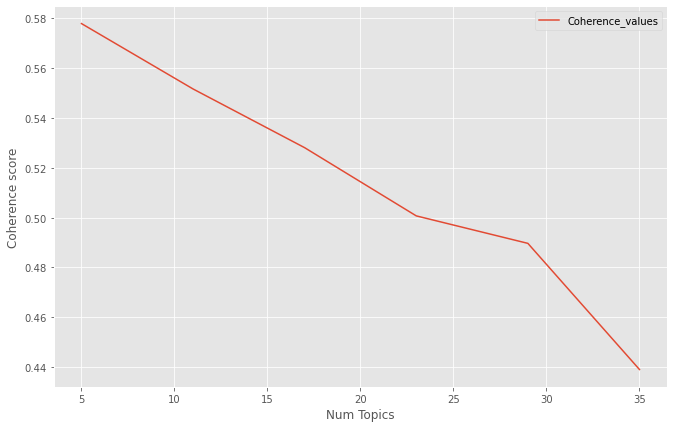

In [30]:
limit=6
start=0
step=1

# model_list, coherence_values = compute_coherence_values(dictionary=bigram_id2word, corpus=bigram_corpus, texts=data_bigrams, start=start, limit=limit, step=step)

# Show graph

x = model_values_df['num_topics'].values.tolist()

plt.figure(figsize=(11,7))

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["Coherence_values"], loc='best')
plt.show()

There is a downward trend in the coherence score as the number of topics increase, hence it would be best to set the number of topics to be **between 10 to 15**.

In [103]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.5779
Num Topics = 11  has Coherence Value of 0.5516
Num Topics = 17  has Coherence Value of 0.5281
Num Topics = 23  has Coherence Value of 0.5007
Num Topics = 29  has Coherence Value of 0.4897
Num Topics = 35  has Coherence Value of 0.439


## Export the pickle file

In [104]:
# Save to file in the current working directory
pkl_filename = "optimal_ldamallet_model.pkl" 
pickle.dump(optimal_model, open(pkl_filename, 'wb'))

## Choosing the topics betweeen 10 and 15

ValueError: x and y must have same first dimension, but have shapes (10,) and (6,)

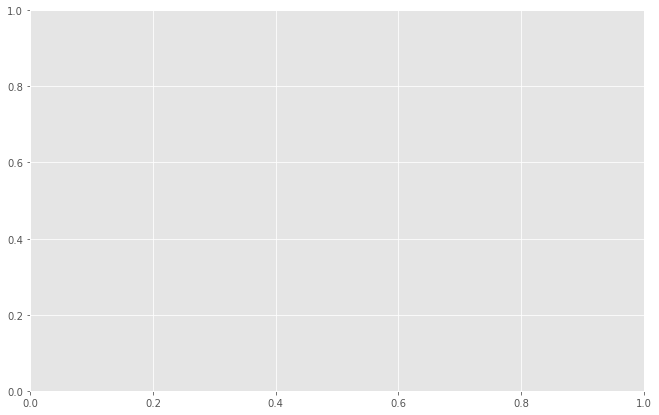

In [105]:
start=5
limit=15
step=1

# model_list, coherence_values = compute_coherence_values(dictionary=bigram_id2word, corpus=bigram_corpus, texts=data_bigrams, start=start, limit=limit, step=step)

# Show graph

x = list(range(start, limit, step))

plt.figure(figsize=(11,7))

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(["coherence_values"], loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

## Selecting the best k topics

It seems **5 topics** is the optimal topic as it shows the highest coherence score, 0.56.

In [ ]:
# Select the optimal model and print the topics
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

# Finding the dominant topic in each sentence

In [31]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Problem: The issue is that the last model **must match** with the last temp_file_doctopics text file.

In [32]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bigram_corpus, texts=data_bigrams)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.2075,"people, time, year, driver, card, buy, gaming,...","[sound, samsung_8nm, cheap]"
1,1,3.0,0.2222,"price, 3080, 3070, 6800, 6800xt, 3090, perform...","[ethic, mongol, invasion, tech]"
2,2,4.0,0.2183,"amd, nvidia, gpu, cpu, memory, gpus, series, e...","[nvidia, software, ai, learning, big, selling,..."
3,3,4.0,0.2807,"amd, nvidia, gpu, cpu, memory, gpus, series, e...","[excited, amd, guy, compete, going, nvidia, br..."
4,4,3.0,0.2426,"price, 3080, 3070, 6800, 6800xt, 3090, perform...","[think, nvidia, actualy, competing, new, conso..."
5,5,4.0,0.2984,"amd, nvidia, gpu, cpu, memory, gpus, series, e...","[reputable, leak, rdna2, say, 40, 50, faster, ..."
6,6,4.0,0.2874,"amd, nvidia, gpu, cpu, memory, gpus, series, e...","[im, sure, amd, good, rdna, generation, rt, im..."
7,7,1.0,0.2257,"card, wait, stock, yeah, launch, lol, release,...","[b4, refresh, ampere, 7nm, throw, dirt, wound,..."
8,8,3.0,0.3570,"price, 3080, 3070, 6800, 6800xt, 3090, perform...","[thread, deleted, aswell, post, r, p, amd, off..."
9,9,3.0,0.2341,"price, 3080, 3070, 6800, 6800xt, 3090, perform...","[amd, going, need, pull, double, performance, ..."


In [53]:
random_value = np.random.randint(100)
df_dominant_topic.iloc[random_value].values

array([12, 4.0, 0.2795,
       'amd, nvidia, gpu, cpu, memory, gpus, series, end, intel, market',
       list(['thought', 'amd', 'competitive', 'nvidia', 'pipeline', 'price', 'plateaued', 'dropped', '100', 'nvidia', 'track_record', 'drop', 'price', 'actually', 'compete'])],
      dtype=object)

## Searching for the best Dirichlet hyperparameters: alpha and beta

I'll be using GridSearch CV to search for the best hyperparameter for
* Alpha: Document-Topic Density
* Beta: Word-Topic Density

## Experimental

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=k,
                             random_state=100,
                             chunksize=100,
                             passes=10,
                             alpha=a,
                             eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = list(range(min_topics, max_topics, step_size))

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)

# corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
#                # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
#                ClippedCorpus(corpus, num_of_docs*0.75), 
#                corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

In [ ]:
# # Can take a long time to run
# if True:
#     #pbar = tqdm.tqdm(total=540)
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[1][i], dictionary=id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('./model_results/lda_tuning_results.csv', index=False)
#     #pbar.close()

# LDA Multicore NOT LDA Mallet

## Bigram: Using 2 topics

In [ ]:
# number of topics
num_topics = 2

# Build LDA model
bigram_lda_model = LdaMulticore(corpus=bigram_corpus, 
                         id2word=bigram_id2word, 
                         num_topics=num_topics,
                         chunksize=100,
                         passes=20, 
                         random_state=42,
                        per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(bigram_lda_model.print_topics())
bigram_doc_lda = bigram_lda_model[bigram_corpus]

## Bigram: Using 3 topics

In [ ]:
# number of topics
num_topics = 3

# Build LDA model
bigram_lda_model = LdaMulticore(corpus=bigram_corpus, 
                         id2word=bigram_id2word, 
                         num_topics=num_topics,
                         chunksize=100,
                         passes=20, 
                         random_state=42,
                        per_word_topics=True)

# Print the Keyword in the 7 topics
pprint(bigram_lda_model.print_topics())
bigram_doc_lda = bigram_lda_model[bigram_corpus]

# Others